In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import sys

In [2]:
conn = sqlite3.connect('/run/media/leyan/8854FE2154FE11A4/ECE143dataset/wildfile/FPA_FOD_20170508.sqlite')

In [3]:
data_dates = pd.read_sql_query("SELECT fire_year, discovery_date FROM fires;", conn)
data_size = pd.read_sql_query("SELECT fire_size, fire_size_class FROM fires;", conn)
data_location = pd.read_sql_query("SELECT latitude, longitude, state FROM fires;", conn)
date = pd.read_sql_query("select datetime(DISCOVERY_DATE) as DISCOVERY_DATE from fires;", conn)

In [5]:
data_dates_arr = date['DISCOVERY_DATE']
fire_year_arr = data_dates['FIRE_YEAR']
fire_size_arr = data_size['FIRE_SIZE']

In [9]:
data_size.groupby('FIRE_SIZE_CLASS').count()

,FIRE_SIZE
FIRE_SIZE_CLASS,
A,666919
B,939376
C,220077
D,28427
E,14107
F,7786
G,3773


In [8]:
data_size.groupby('FIRE_SIZE_CLASS').mean()

,FIRE_SIZE
FIRE_SIZE_CLASS,
A,0.118801
B,2.146998
C,28.531914
D,161.801034
E,512.854904
F,2130.395128
G,27388.190703


In [16]:
size_class = []
for c in data_size['FIRE_SIZE_CLASS']:
    d = {"A":1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    size_class.append(d[c])

In [17]:
df = data_location
df['date'] = data_dates_arr
df['fire_class'] = size_class

In [18]:
df.describe

<bound method NDFrame.describe of           LATITUDE   LONGITUDE STATE                 date  fire_class
0        40.036944 -121.005833    CA  2005-02-02 00:00:00           1
1        38.933056 -120.404444    CA  2004-05-12 00:00:00           1
2        38.984167 -120.735556    CA  2004-05-31 00:00:00           1
3        38.559167 -119.913333    CA  2004-06-28 00:00:00           1
4        38.559167 -119.933056    CA  2004-06-28 00:00:00           1
...            ...         ...   ...                  ...         ...
1880460  40.481637 -122.389375    CA  2015-09-26 00:00:00           1
1880461  37.617619 -120.938570    CA  2015-10-05 00:00:00           1
1880462  37.617619 -120.938570    CA  2015-05-02 00:00:00           1
1880463  37.672235 -120.898356    CA  2015-10-14 00:00:00           2
1880464  34.263217 -116.830950    CA  2015-03-14 00:00:00           1

[1880465 rows x 5 columns]>

# randomly select 3500 samples, 500 for each class

In [20]:
sample_df = pd.DataFrame()
num_samples = 500
for i in range(1, 8):
    s = df[df['fire_class'] == i].sample(n = num_samples)
    sample_df = pd.concat([sample_df, s])
print(sample_df)

          LATITUDE   LONGITUDE STATE                 date  fire_class
17447    34.150278 -111.161111    AZ  2006-07-08 00:00:00           1
1408617  34.549600  -83.314900    GA  1997-09-05 00:00:00           1
1774717  38.932217 -121.090600    CA  2014-02-26 00:00:00           1
661920   37.474330  -78.271670    VA  2006-03-11 00:00:00           1
69324    34.443333 -118.091667    CA  1994-05-15 00:00:00           1
...            ...         ...   ...                  ...         ...
1564624  45.534167 -116.297500    ID  2012-09-06 00:00:00           7
358740   35.507217  -83.457391    NC  2001-11-10 00:00:00           7
628216   33.513660 -102.827900    TX  2006-03-12 00:00:00           7
330099   43.146400 -113.563900    ID  2007-08-16 00:00:00           7
305615   65.516900 -143.172400    AK  2004-06-14 00:00:00           7

[3500 rows x 5 columns]


# correlate with monthly average wind speed

In [5]:
import os 
import numpy as np
import iris   

import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
from iris.time import PartialDateTime

In [22]:
PATH = "/run/media/leyan/8854FE2154FE11A4/ECE143dataset/adaptor.mars.internal.nc"

In [23]:
raw = iris.load_raw(PATH)
print(raw)

0: 10 metre wind speed / (m s**-1)     (time: 493; expver: 2; latitude: 721; longitude: 1440)
1: surface_air_pressure / (Pa)         (time: 493; expver: 2; latitude: 721; longitude: 1440)


In [24]:
cube = raw[0] # cube0 is 10 metre wind speed
cube = cube.extract(iris.Constraint(expver = 1))

In [25]:
def query_wind(y, m, lat, long, cube):
    """
    Args:
        year: integer indicate year, support 1979 to 2019
        month: integer indicate month, 1 to 12
        latitude: float, -90 to 90, resolution 0.25
        longitude: float, 0 to 360, 5 means East5, 185 means West175, resolution 0.25
        cube: precipation data
    Return:
        the average precipation in that given month (mm/day)
        its type is float  
    """
    if long < 0:
        long += 360
    time_cons = iris.Constraint(time = PartialDateTime(year = y, month = m))
    lat_cons = iris.Constraint(latitude = lambda x : lat-0.125 <= x <lat+0.125)
    long_cons = iris.Constraint(longitude = lambda x : long-0.125 <= x <long+0.125)
#     exp_cons = iris.Constraint(expver = 1)
    wind = cube.extract(lat_cons & long_cons & time_cons)
#     print(rain.data)
    return float(wind.data) # only one answer

In [26]:
wind_series = []
for index, row in sample_df.iterrows():
    print(index)
    date_list = row['date'].split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    lat = row['LATITUDE']
    long = row['LONGITUDE']
    wind_series.append(query_wind(year, month, lat, long, cube))

17447
1408617
1774717
661920
69324
425489
1789747
355508
33913
1292488
712532
1007951
1871581
1460051
1031310
1868928
1137204
311165
676983
1611807
336346
1310050
391533
192458
551915
750115
1733355
940323
41468
1579520
1013678
1607710
298406
661356
56747
1370708
34119
688078
1483934
463001
1662419
823420
1127228
267106
668639
405428
799189
1363641
1111675
991146
20526
420301
949287
1097732
946098
363874
96890
536015
23510
273
2621
23503
408211
218205
1867696
428368
730317
1642657
262133
1248667
1443803
1660610
1469184
1424041
76655
1060459
542276
796867
1341725
138095
369110
114323
32893
327010
1591845
516993
311222
1445743
1372202
1054879
1256484
1195433
28385
922445
1189975
1095161
1644619
7863
62395
84478
1033467
350128
462822
1869192
1330054
1642221
333548
348382
280403
791308
31041
139285
1310340
1408048
453004
1676448
1563248
158691
1737407
1142132
719726
757217
312159
1370511
983859
1880389
713363
1593393
1743376
830247
326828
161208
1621920
224652
676471
511757
77196
505645
18

810858
190324
1270432
595061
1553191
1557367
736123
1377029
307742
648306
1823372
372797
1015616
59372
1320449
1733928
842630
1783734
448202
1632917
698458
565369
1836362
188726
1706099
1617726
468283
182461
630073
931496
1860294
1019764
786066
963985
493873
1710403
241194
1377443
1267131
1452772
1637589
1670652
329250
28072
1523247
586251
738263
1169140
568552
896151
1533686
1022388
225908
1268612
745382
959843
307582
725900
492570
520191
649698
1164758
377213
656808
369517
1220770
1693989
1202872
548882
1037509
1323583
700501
937127
835468
486778
1802473
1499730
1211255
1161143
470757
1477994
1505627
751996
430704
1356247
567657
1834601
1682004
1574029
632505
1158400
182102
821864
477451
1495472
1321917
1174908
1210978
604683
1839750
941480
861219
1458458
494305
1648188
632312
1212089
1439540
1366098
135823
1825300
1640628
522520
1157339
1591479
1171244
112960
589362
247751
783536
435235
925939
765806
1368663
372014
1662405
820236
1160898
263901
1314216
775933
610093
997064
606072
12

391472
1079436
336755
1558621
609876
213888
1360195
280151
1122662
1229742
1525949
364027
709333
44701
766691
211415
194307
489587
464057
131740
1065775
1549576
1801843
408890
1823148
1134826
1735994
1114632
176740
361719
348585
1799018
1526714
248759
216445
590976
3634
372661
226059
1571062
1525138
1140813
367336
25135
779016
236242
158910
1648083
313076
1067699
311141
211110
8366
331398
683570
1544599
83820
529099
1064478
803600
887815
1461882
631333
350863
337591
349113
85552
1066074
1722207
1789342
1720596
1538047
1064050
1215557
802995
173046
224366
308105
160759
594218
234368
1459071
1100949
562124
1636679
225181
339740
1499889
359392
1160607
779499
1360458
231144
635765
994909
351613
646415
334009
207519
306371
592148
639909
506854
1445275
1324150
309468
216113
631143
174162
1577916
1810217
1542092
531328
329982
1065803
1801943
363022
332834
1176454
86127
619076
213935
1525750
1268844
416003
1803242
1229313
350165
1637216
805181
1366838
1721881
138207
1804562
1060043
884943
7491

335638
1581646
153237
344638
305862
1467757
335664
230878
1525313
1796405
341737
1647480
72915
756337
1059454
342374
1069673
558822
1522750
334026
153902
349302
256233
117552
1565144
380226
230867
306635
69382
1727113
1215348
361636
549833
337232
1566747
306534
371977
305443
306647
1664766
305637
248782
211518
1776009
1526824
1804662
306589
399197
110863
1796580
764755
355106
327633
1524459
230167
1060040
1216863
1522051
1564103
230386
1569614
352796
1640144
332099
616806
1731023
1635695
1571421
1804714
1649025
30797
1525497
1643764
1577741
308327
24781
345803
1521240
492881
1470357
1641693
1470350
1066264
561959
1579594
352608
37644
558692
1796544
224901
236647
196557
62082
306005
198177
1643037
142322
230938
223665
211329
306588
1804641
305947
210546
1305850
752145
225294
211275
161550
1572837
1497014
73554
307586
210924
306502
1790001
224218
305704
330307
558708
24174
308302
1803873
654127
1731188
257086
237795
380252
334187
1573774
681210
1563934
1804888
1795194
234390
1721847
1735

In [27]:
sample_df['wind'] = wind_series

In [28]:
sample_df.describe

<bound method NDFrame.describe of           LATITUDE   LONGITUDE STATE                 date  fire_class  \
17447    34.150278 -111.161111    AZ  2006-07-08 00:00:00           1   
1408617  34.549600  -83.314900    GA  1997-09-05 00:00:00           1   
1774717  38.932217 -121.090600    CA  2014-02-26 00:00:00           1   
661920   37.474330  -78.271670    VA  2006-03-11 00:00:00           1   
69324    34.443333 -118.091667    CA  1994-05-15 00:00:00           1   
...            ...         ...   ...                  ...         ...   
1564624  45.534167 -116.297500    ID  2012-09-06 00:00:00           7   
358740   35.507217  -83.457391    NC  2001-11-10 00:00:00           7   
628216   33.513660 -102.827900    TX  2006-03-12 00:00:00           7   
330099   43.146400 -113.563900    ID  2007-08-16 00:00:00           7   
305615   65.516900 -143.172400    AK  2004-06-14 00:00:00           7   

             wind  
17447    1.885379  
1408617  2.074109  
1774717  2.425365  
661920   

In [29]:
sample_df = sample_df.drop(columns=['STATE'])

In [30]:
sample_df

,LATITUDE,LONGITUDE,date,fire_class,wind
17447,34.150278,-111.161111,2006-07-08 00:00:00,1,1.885379
1408617,34.549600,-83.314900,1997-09-05 00:00:00,1,2.074109
1774717,38.932217,-121.090600,2014-02-26 00:00:00,1,2.425365
661920,37.474330,-78.271670,2006-03-11 00:00:00,1,3.078590
69324,34.443333,-118.091667,1994-05-15 00:00:00,1,2.529557
...,...,...,...,...,...
1564624,45.534167,-116.297500,2012-09-06 00:00:00,7,1.462686
358740,35.507217,-83.457391,2001-11-10 00:00:00,7,2.028876
628216,33.513660,-102.827900,2006-03-12 00:00:00,7,5.170843
330099,43.146400,-113.563900,2007-08-16 00:00:00,7,4.055931


In [31]:
sample_df.to_csv('./sample_with_wind.csv')

In [9]:
sample_df = pd.read_csv('./sample_with_wind.csv')
sample_df.describe

<bound method NDFrame.describe of       Unnamed: 0   LATITUDE   LONGITUDE                 date  fire_class  \
0          17447  34.150278 -111.161111  2006-07-08 00:00:00           1   
1        1408617  34.549600  -83.314900  1997-09-05 00:00:00           1   
2        1774717  38.932217 -121.090600  2014-02-26 00:00:00           1   
3         661920  37.474330  -78.271670  2006-03-11 00:00:00           1   
4          69324  34.443333 -118.091667  1994-05-15 00:00:00           1   
...          ...        ...         ...                  ...         ...   
3495     1564624  45.534167 -116.297500  2012-09-06 00:00:00           7   
3496      358740  35.507217  -83.457391  2001-11-10 00:00:00           7   
3497      628216  33.513660 -102.827900  2006-03-12 00:00:00           7   
3498      330099  43.146400 -113.563900  2007-08-16 00:00:00           7   
3499      305615  65.516900 -143.172400  2004-06-14 00:00:00           7   

          wind  
0     1.885379  
1     2.074109  
2 

# correlate with precipitation

In [6]:
PATH = os.path.join(os.getcwd(), "precip.mon.mean.nc")
rain_cube = iris.load_cube(PATH)
print(rain_cube.shape)

(492, 72, 144)


In [7]:
def query_rain(y, m, lat, long, cube):
    """
    Args:
        year: integer indicate year, support 1979 to 2019
        month: integer indicate month, 1 to 12
        latitude: float, -90 to 90
        longitude: float, 0 to 360, 5 means East5, 185 means West175
        cube: precipation data
    Return:
        the average precipation in that given month (mm/day)
        its type is float  
    """
    if long < 0:
        long += 360
    time_cons = iris.Constraint(time = PartialDateTime(year = y, month = m))
    lat_cons = iris.Constraint(latitude = lambda x : lat-1.25 <= x <lat+1.25)
    long_cons = iris.Constraint(longitude = lambda x : long-1.25 <= x <long+1.25)
    rain = cube.extract(lat_cons & long_cons & time_cons)
#     print(rain.data)
    return float(rain.data) # only one answer

In [10]:
rain_series = []
for index, row in sample_df.iterrows():
    print(index)
    date_list = row['date'].split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    lat = row['LATITUDE']
    long = row['LONGITUDE']
    rain_series.append(query_rain(year, month, lat, long, rain_cube))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


In [11]:
rain_series

[1.6200000047683716,
 3.5399999618530273,
 4.550000190734863,
 0.7599999904632568,
 0.14000000059604645,
 2.890000104904175,
 0.8299999833106995,
 0.05000000074505806,
 0.8899999856948853,
 1.3300000429153442,
 0.009999999776482582,
 2.309999942779541,
 0.09000000357627869,
 1.6200000047683716,
 3.440000057220459,
 0.4399999976158142,
 0.07000000029802322,
 0.03999999910593033,
 2.619999885559082,
 4.440000057220459,
 0.75,
 4.269999980926514,
 0.23000000417232513,
 0.05000000074505806,
 2.4200000762939453,
 0.11999999731779099,
 0.47999998927116394,
 1.2699999809265137,
 0.07000000029802322,
 0.25999999046325684,
 2.869999885559082,
 0.5299999713897705,
 1.1200000047683716,
 3.2300000190734863,
 0.3799999952316284,
 1.7100000381469727,
 0.14000000059604645,
 0.8700000047683716,
 3.4200000762939453,
 0.3100000023841858,
 0.23999999463558197,
 1.0,
 0.6800000071525574,
 0.47999998927116394,
 1.5,
 3.140000104904175,
 2.4700000286102295,
 1.4700000286102295,
 0.28999999165534973,
 9.3000

In [12]:
sample_df['rain'] = rain_series

In [14]:
sample_df.to_csv('./sample_with_rain.csv')

In [17]:
sample_df_show = sample_df.drop(columns=['date', 'Unnamed: 0'])

In [18]:
sample_df_show

,LATITUDE,LONGITUDE,fire_class,wind,rain
0,34.150278,-111.161111,1,1.885379,1.62
1,34.549600,-83.314900,1,2.074109,3.54
2,38.932217,-121.090600,1,2.425365,4.55
3,37.474330,-78.271670,1,3.078590,0.76
4,34.443333,-118.091667,1,2.529557,0.14
...,...,...,...,...,...
3495,45.534167,-116.297500,7,1.462686,0.12
3496,35.507217,-83.457391,7,2.028876,1.65
3497,33.513660,-102.827900,7,5.170843,0.34
3498,43.146400,-113.563900,7,4.055931,0.07


In [19]:
corr = sample_df_show.corr()

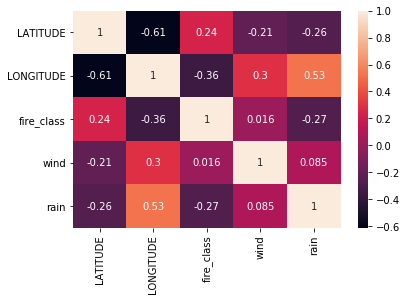

In [20]:
plt.figure()
sns.heatmap(corr,annot = True)
plt.show()

# correlate with near surface air pressure

In [22]:
PATH = "/run/media/leyan/8854FE2154FE11A4/ECE143dataset/adaptor.mars.internal.nc"
raw = iris.load_raw(PATH)
print(raw)
cube = raw[0] # cube0 is 10 metre wind speed
cube = cube.extract(iris.Constraint(expver = 1))

0: surface_air_pressure / (Pa)         (time: 493; expver: 2; latitude: 721; longitude: 1440)
1: 10 metre wind speed / (m s**-1)     (time: 493; expver: 2; latitude: 721; longitude: 1440)


In [23]:
cube

<iris 'Cube' of surface_air_pressure / (Pa) (time: 493; latitude: 721; longitude: 1440)>

In [26]:
air_pressure_series = []
for index, row in sample_df.iterrows():
    print(index)
    date_list = row['date'].split('-')
    year = int(date_list[0])
    month = int(date_list[1])
    lat = row['LATITUDE']
    long = row['LONGITUDE']
    air_pressure_series.append(query_wind(year, month, lat, long, cube))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [28]:
sample_df['air_pressure'] = air_pressure_series
sample_df.to_csv('./sample_with_air_pressure.csv')

In [29]:
sample_df

,Unnamed: 0,LATITUDE,LONGITUDE,date,fire_class,wind,rain,air_pressure
0,17447,34.150278,-111.161111,2006-07-08 00:00:00,1,1.885379,1.62,83488.001293
1,1408617,34.549600,-83.314900,1997-09-05 00:00:00,1,2.074109,3.54,98583.801239
2,1774717,38.932217,-121.090600,2014-02-26 00:00:00,1,2.425365,4.55,95627.461316
3,661920,37.474330,-78.271670,2006-03-11 00:00:00,1,3.078590,0.76,100349.321228
4,69324,34.443333,-118.091667,1994-05-15 00:00:00,1,2.529557,0.14,88059.714344
...,...,...,...,...,...,...,...,...
3495,1564624,45.534167,-116.297500,2012-09-06 00:00:00,7,1.462686,0.12,86285.565225
3496,358740,35.507217,-83.457391,2001-11-10 00:00:00,7,2.028876,1.65,90951.335792
3497,628216,33.513660,-102.827900,2006-03-12 00:00:00,7,5.170843,0.34,88579.187967
3498,330099,43.146400,-113.563900,2007-08-16 00:00:00,7,4.055931,0.07,84636.538490


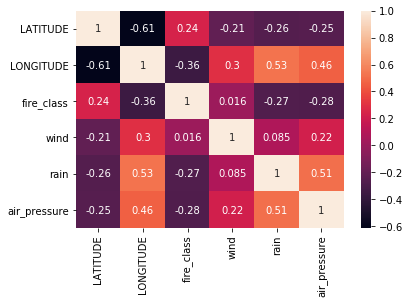

In [31]:
sample_df_show = sample_df.drop(columns=['date', 'Unnamed: 0'])
corr = sample_df_show.corr()
plt.figure()
sns.heatmap(corr,annot = True)
plt.show()